In [1]:
from pandas import Series
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

Using TensorFlow backend.


In [2]:
def parser(x):
    return datetime.strptime(x, '%y%m%d')
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [40]:
def difference(dataset, interval =5):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 5)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values),1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values),1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [41]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:,0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size = n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [42]:
def forecast_lstm(model, X, n_batch):
    X = X.reshape(1,1,len(X))
    forecast = model.predict(X, batch_size= n_batch)
    return [x for x in forecast[0,:]]
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts



In [43]:
def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0,:]
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

In [44]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for  forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
def plot_forecasts(series, forecasts, n_test):
    pyplot.plot(series.values)
    for i in range(len(forecasts)):
        off_s = (len(series) - n_test + i - 1)
        off_e = off_s + len(forecasts[i]) 
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = series.values[off_s] + forecasts[i]
        pyplot.plot(xaxis, forecasts[i], color='red')
    pyplot.show()

TIME
2013-10-28    2133
2013-10-29    2135
2013-10-30    2126
2013-10-31    2155
2013-11-01    2139
Name: STOCK, dtype: int64


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


[[ 0.20183486  0.02752294  0.20183486 -0.18348624 -0.18348624 -0.49541284
  -0.27522936 -0.30275229 -0.4587156  -0.19266055  0.39449541  0.79816514
   0.76146789  1.          0.96330275  0.34862385 -0.13761468 -0.19266055]
 [ 0.02752294  0.20183486 -0.18348624 -0.18348624 -0.49541284 -0.27522936
  -0.30275229 -0.4587156  -0.19266055  0.39449541  0.79816514  0.76146789
   1.          0.96330275  0.34862385 -0.13761468 -0.19266055  0.05504587]
 [ 0.20183486 -0.18348624 -0.18348624 -0.49541284 -0.27522936 -0.30275229
  -0.4587156  -0.19266055  0.39449541  0.79816514  0.76146789  1.
   0.96330275  0.34862385 -0.13761468 -0.19266055  0.05504587  0.12844037]
 [-0.18348624 -0.18348624 -0.49541284 -0.27522936 -0.30275229 -0.4587156
  -0.19266055  0.39449541  0.79816514  0.76146789  1.          0.96330275
   0.34862385 -0.13761468 -0.19266055  0.05504587  0.12844037  0.14678899]
 [-0.18348624 -0.49541284 -0.27522936 -0.30275229 -0.4587156  -0.19266055
   0.39449541  0.79816514  0.76146789  1.  

t+1 RMSE: 46.215139
t+2 RMSE: 92.778431
t+3 RMSE: 138.145152
t+4 RMSE: 186.334174
t+5 RMSE: 229.024114
t+6 RMSE: 266.384162
t+7 RMSE: 301.976431
t+8 RMSE: 334.677646
t+9 RMSE: 363.328967


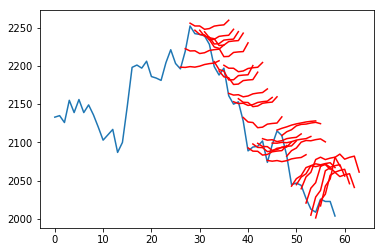

In [48]:
series = read_csv('stocktest.csv', header = 0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
n_lag = 9
n_seq = 9
n_test = 30
n_epochs = 1
n_batch = 1
n_neurons = 1
#train, test = prepare_data(series, n_test, n_lag, n_seq)
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
print(train ,test)
print('Train: %s, Test: %s' % (train.shape, test.shape))
#forecasts = make_forecasts(train, test, n_lag, n_seq)
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, scaler , n_test + 2)
actual = [row[n_lag:] for row in test]
acutal = inverse_transform(series, actual, scaler, n_test + 2)
evaluate_forecasts(acutal, forecasts, n_lag, n_seq)
plot_forecasts(series, forecasts, n_test + 2)